In [1]:
# import reframed
import cobra
import pandas as pd
import numpy as np
from pathlib import Path
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns


# Analyse fluxes, shadow prices, growth and changes in intracellular concentrations to choose KO strains

In [2]:
model = cobra.io.read_sbml_model('../../models/e_coli/momentiJO1366_modified.xml')

# Use the original iJO1366 model for getting info about gene names
modeli = cobra.io.read_sbml_model('../../models/e_coli/iJO1366.xml')


Set parameter Username
Set parameter LicenseID to value 2586336
Academic license - for non-commercial use only - expires 2025-11-18


Adding exchange reaction EX_12ppd__R_e with default bounds for boundary metabolite: 12ppd__R_e.
Adding exchange reaction EX_12ppd__S_e with default bounds for boundary metabolite: 12ppd__S_e.
Adding exchange reaction EX_14glucan_e with default bounds for boundary metabolite: 14glucan_e.
Adding exchange reaction EX_15dap_e with default bounds for boundary metabolite: 15dap_e.
Adding exchange reaction EX_23camp_e with default bounds for boundary metabolite: 23camp_e.
Adding exchange reaction EX_23ccmp_e with default bounds for boundary metabolite: 23ccmp_e.
Adding exchange reaction EX_23cgmp_e with default bounds for boundary metabolite: 23cgmp_e.
Adding exchange reaction EX_23cump_e with default bounds for boundary metabolite: 23cump_e.
Adding exchange reaction EX_23dappa_e with default bounds for boundary metabolite: 23dappa_e.
Adding exchange reaction EX_26dap__M_e with default bounds for boundary metabolite: 26dap__M_e.
Adding exchange reaction EX_2ddglcn_e with default bounds for bo

### Knockout gene b4301 because it is seems to be a wrongly annotated homolog of rpe

In [3]:
model.genes.get_by_id('b4301').knock_out() #This seems to be wrongly annotated rpe homolog

# Set M9 galactose environment

In [4]:
# M9
uptake = ['EX_nh4_e', 'EX_pi_e', 'EX_so4_e', 'EX_h2o_e', 'EX_h_e', 'EX_o2_e', 'EX_fe2_e', 'EX_fe3_e', 'EX_cobalt2_e', 'EX_ca2_e', 'EX_cl_e', 
       'EX_cu2_e','EX_k_e', 'EX_mg2_e', 'EX_mn2_e','EX_zn2_e', 'EX_mobd_e', 'EX_ni2_e', 'EX_na1_e']

for r in model.exchanges:
    r.lower_bound = 0
for r_id in uptake:
    model.reactions.get_by_id(r_id).lower_bound = -1000
    model.reactions.get_by_id(r_id).upper_bound = 1000
model.reactions.EX_gal_e.lower_bound = -10
print(model.optimize())

<Solution 0.490 at 0x105bb9cd0>


In [5]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
prot_pool,ER_pool_TG_,0.095,0,0.00%
ca2_e,EX_ca2_e,0.002553,0,0.00%
cl_e,EX_cl_e,0.002553,0,0.00%
cobalt2_e,EX_cobalt2_e,1.226E-05,0,0.00%
cu2_e,EX_cu2_e,0.0003478,0,0.00%
fe2_e,EX_fe2_e,0.007878,0,0.00%
gal_e,EX_gal_e,6.39,6,100.00%
k_e,EX_k_e,0.09574,0,0.00%
mg2_e,EX_mg2_e,0.004255,0,0.00%
mn2_e,EX_mn2_e,0.0003389,0,0.00%


# Do gene knockouts

In [6]:
genes = [g.id for g in model.genes]
essential_genes = []
pfba_sol_wt = cobra.flux_analysis.pfba(model)
sol_wt = model.optimize()
wt_growth = sol_wt.objective_value
for gene in genes:
    with model:
        g = model.genes.get_by_id(gene)
        g.knock_out()
        sol = model.slim_optimize()
        if sol < wt_growth*0.1:
            essential_genes.append(gene)
    

In [7]:
non_essential_genes = [g for g in genes if not g in essential_genes]

In [8]:
data = []
fluxes_dict = {}
shadow_price_dict = {}
fluxes_dict['WT'] = sol_wt.fluxes
for gene in non_essential_genes:
    with model:
        model.genes.get_by_id(gene).knock_out()
        sol = model.optimize()
        try:
            pfba_sol = cobra.flux_analysis.pfba(model)
        except:
            continue

        # Correlations between fluxes
        flux_pcorr, flux_ppval  = st.pearsonr(pfba_sol.fluxes, pfba_sol_wt.fluxes)
        flux_scorr, flux_spval  = st.spearmanr(pfba_sol.fluxes, pfba_sol_wt.fluxes)

        # Correlations between shadow prices
        sp_pcorr, sp_ppval  = st.pearsonr(pfba_sol.shadow_prices, pfba_sol_wt.shadow_prices)
        sp_scorr, sp_spval  = st.spearmanr(pfba_sol.shadow_prices, pfba_sol_wt.shadow_prices)
        data.append([gene, sol.objective_value, flux_pcorr, flux_ppval, flux_scorr, flux_spval, sp_pcorr, sp_ppval, sp_scorr, sp_spval])
        fluxes_dict[gene] = pfba_sol.fluxes
        shadow_price_dict[gene] = sol.shadow_prices

/Users/snorre/miniconda3/envs/reframed/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [9]:
shadow_price_dict['WT'] = sol_wt.shadow_prices

In [10]:
df = pd.DataFrame(data, columns=['Gene','Growth rate', 'Flux pearson correlation', 'Flux pearson p-value', 'Flux spearman correlation', 'Flux spearman p-value',
                                        'Shadow price pearson correlation', 'Shadow price pearson p-value', 'Shadow price spearman correlation', 'Shadow price spearman p-value'])

In [11]:
gene_name_dict = {g.id:g.name for g in modeli.genes}
gene_name_dict['WT'] = 'Wild-type'
df['Gene name'] = df.Gene.map(gene_name_dict)
df['Normalized growth rate'] = df['Growth rate']/wt_growth

## Read in metabolomics data

In [12]:
metabolomics_folder = Path('../../data/fuhrer_2017/')
neg_zscore = pd.read_csv(metabolomics_folder/'zscore_neg.tsv', sep = '\t', header=None)
pos_zscore = pd.read_csv(metabolomics_folder/'zscore_pos.tsv', sep = '\t', header=None)

In [13]:
zscores = pd.concat([neg_zscore, pos_zscore])

In [14]:
met_info = pd.read_csv(metabolomics_folder / 'metabolite_info.csv')
met_info = met_info.iloc[1:,:4]

In [15]:
sample_info = pd.read_csv(metabolomics_folder / 'strain_ids.csv', header=None)

In [16]:
zscores.columns = [x[0] for x in sample_info.values]

In [17]:
n_changes = (zscores.abs() > 5).sum().sort_values(ascending = False) # This is the 0.1% most significant changes they use in the paper. 
n_changes_001 = (zscores.abs() > 3.291).sum().sort_values(ascending = False)
# Can also e.g. use 3.291, corresponding to a p+value of 0.001. See https://www.calculator.net/z-score-calculator.html?c2z=&c2p=&c2pg=&c2p0=&c2pin=&c2pout=0.001&calctype=converter&x=Calculate#converter for other values

In [18]:
n_changes.head(30)

rpmG    560
msrA    430
nuoA    410
glcB    354
talA    271
tap     244
bglA    231
yhbT    218
yafY    206
upp     206
cysH    200
purR    193
kdpD    187
rcsC    186
ybhP    184
uhpA    181
cpxR    181
uhpB    179
ybeX    176
rpoN    175
dkgA    162
yhdL    162
lomR    151
ybiW    150
cheY    136
pmbA    136
nuoN    135
gltA    135
dld     134
potH    132
dtype: int64

In [19]:
bc = np.bincount(n_changes)

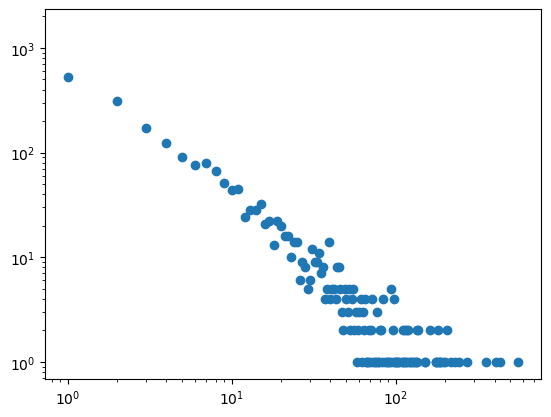

In [20]:
plt.scatter(np.arange(len(bc)), bc)
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, 'Number of strains')

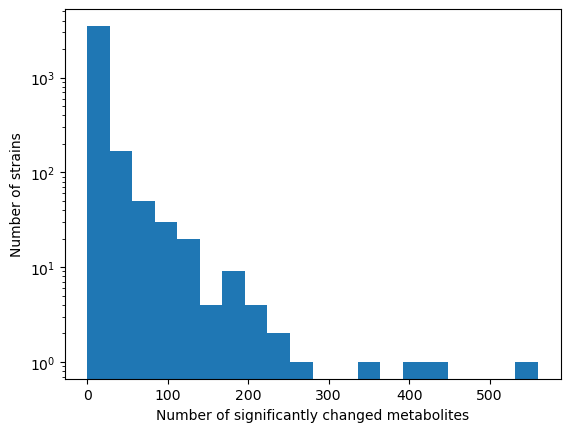

In [21]:
plt.hist(n_changes, bins = 20)
plt.yscale('log')
plt.xlabel('Number of significantly changed metabolites')
plt.ylabel('Number of strains')

# Plot N changes in metabolite values vs correlation

ldcA 0.9778173316247611 32
cusA 0.9819089826976262 39
cusF 0.9819089826976262 47
sucB 0.9563408124896685 43
cyoC 0.9460937154655802 45
cyoD 0.9460937154655802 61
fhuA 0.977816520650528 39
galM 0.9819089934025189 43
aceE 0.9880444450564402 84
pgi 0.9697638046587227 54
pstA 0.9819081825795668 115
pstC 0.9819081825795668 79
pstS 0.9819081825795668 68
ppk 0.9532249060986719 31
sufE 0.9690492477295618 39
selA 0.9819081940506903 60
sdhC 0.9555396377849303 31
sdhD 0.9555396377849303 46
sucC 0.9632438972059215 44
tpiA 0.9541080018244835 90


(0.95, 1.0)

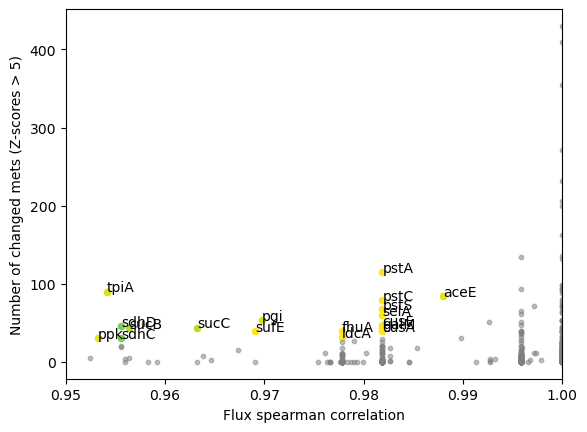

In [22]:
fig, ax = plt.subplots(1)
kind = 'spearman'
j = 0
for i, row in df.iterrows():
    x = row[f'Flux {kind} correlation']
    try:
        y = n_changes[row["Gene name"]]
    except KeyError:
        # print(i, row["Gene name"])
        continue
    else:
        j+=1
        # print(i, row["Gene name"], y)
    if ((x < 0.99) and (y> 30)):
        ax.scatter(x,y, c = row['Normalized growth rate'],
                   vmin= df['Normalized growth rate'].min(),vmax=df['Normalized growth rate'].max(), s = 20)
        ax.annotate(row['Gene name'], (x, y))
        print(row['Gene name'], x, y)
    else:
        ax.scatter(x,y, c = 'gray', s = 10, alpha = 0.5)
        
        
plt.ylabel(f'Number of changed mets (Z-scores > 5)')
plt.xlabel(f'Flux {kind} correlation')
# plt.ylim(0.5, 0.7)
plt.xlim(0.95, 1)
# plt.scatter(df['Flux pearson correlation'], df['Shadow price pearson correlation'], c = df['Normalized growth rate'])
# plt.colorbar(ax)

cyoD 0.9460937154655802 61
aceE 0.9880444450564402 84
pgi 0.9697638046587227 54
pstA 0.9819081825795668 115
pstC 0.9819081825795668 79
pstS 0.9819081825795668 68
selA 0.9819081940506903 60
tpiA 0.9541080018244835 90


Text(0.5, 0, 'Flux spearman correlation')

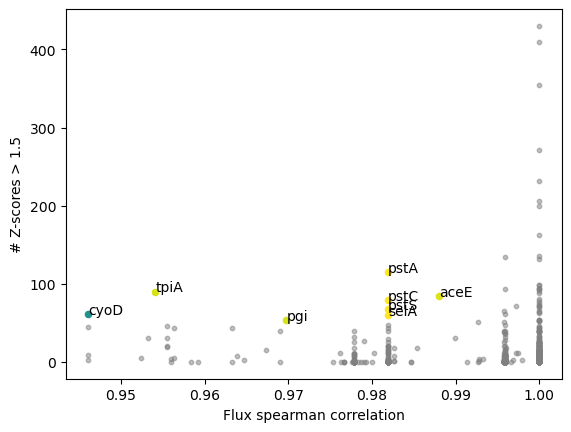

In [23]:
fig, ax = plt.subplots(1)
kind = 'spearman'
j = 0
for i, row in df.iterrows():
    x = row[f'Flux {kind} correlation']
    try:
        y = n_changes[row["Gene name"]]
    except KeyError:
        # print(i, row["Gene name"])
        continue
    else:
        j+=1
        # print(i, row["Gene name"], y)
    if ((x < 0.99) and (y> 50)) or (y > 480):
        ax.scatter(x,y, c = row['Normalized growth rate'],
                   vmin= df['Normalized growth rate'].min(),vmax=df['Normalized growth rate'].max(), s = 20)
        ax.annotate(row['Gene name'], (x, y))
        print(row['Gene name'], x, y)
    else:
        ax.scatter(x,y, c = 'gray', s = 10, alpha = 0.5)
        
        
plt.ylabel(f'# Z-scores > 1.5')
plt.xlabel(f'Flux {kind} correlation')
# plt.ylim(0.5, 0.7)
# plt.xlim(0.9, 1)
# plt.scatter(df['Flux pearson correlation'], df['Shadow price pearson correlation'], c = df['Normalized growth rate'])
# plt.colorbar(ax)

# Notes
- glcB: Anaplerotic reaction in TCA from glyoxylate to malate
- dld: lactate to pyruvate
- talA: PPP (interesting!)
- nuoA: Electron transport chain
- fadB: degradation of fatty acids via the β-oxidation cycle
- cyoD: cytochrome electron transport chain
- ackA: acetate to acetyl-phosphate,  propionyl-CoA metabolism
- pfkA, 6-phosphofructokinase I;, glycolysis
- tktB: transketolase, PPP
- rpmG: ribosomal subunit
- msrA: methionine sulfoxide reductases, repairs oxidized methionine residues on proteins
- tap: chemotaxis
- purR: Regulatory gene, PurR dimer controls several genes involved in purine nucleotide biosynthesis and its own synthesis
- uhpA: UhpBA two-component signal transduction system (TCS) forms part of the E. coli Uhp system which is responsible for sensing and transport of the metabolic intermediate, glucose-6-phosphate.
- pldA: Outer membrane somethin
- glk: GLucose to glucose 6-phosphate
- pgi:
- sdhB: succinate:quinone oxidoreductase
- tpiA: D-glyceraldehyde 3-phosphate ⇄ glycerone phosphate
- frdA: Fumarate reductase, anaerobic respiration
- adhE: aldehyde/alcohol dehydrogenase AdhE
- dkgA: methylglyoxal reductase DkgA
# Other comments:
- eno: Essential
- rcsC: Regulator/signalling
- cysH: sulfate reduction, 3'-Phospho-adenylylsulfate reductase (CysH) is involved in the assimilation of sulfate and catalyzes the reduction of 3'-phospho-adenylylsulfate (PAPS) to sulfite and PAP. As a consequence of this and a subsequent reaction, the adenylate removed from the cell at the initiation of the cysteine biosynthetic pathway is returned as AMP
- ppc: Essential in MM according to ecocyc
- glyA: Essential


# Plot selected gene KOs

In [24]:

selected_genes = ['nuoA', 'pgi', 'cyoD', 'sucB', 'sdhB', 'rpe', 'aceE', 'lacA']#rpmG #'zwf',tpiA
selected_genes = sorted(selected_genes)
name_gene_dict = {name:gene for gene, name in gene_name_dict.items()}
selected_gene_ids = [name_gene_dict[x] for x in selected_genes if name_gene_dict.get(x)]
selected_gene_ids += ['WT']
colors = sns.color_palette('tab20')

In [25]:
strain_cmap =plt.get_cmap('tab10', 10)
strain_colors = {
    'WT': strain_cmap(0),
    'aceE': strain_cmap(1),
    'cyoD': strain_cmap(2),
    'nuoA': strain_cmap(3),
    'pgi': strain_cmap(5),
    'rpe': strain_cmap(6),
    'sucB': strain_cmap(8),
    'lacA': strain_cmap(7),
    'sdhB': strain_cmap(9),
    # 'tpiA': strain_cmap(4),
    # 'zwf': strain_cmap(0),
}

In [26]:
figure_folder = Path('../../SupplementalFigures/')

aceE 84
cyoD 61
lacA 2
nuoA 410
pgi 54
rpe 72
sdhB 19
sucB 43


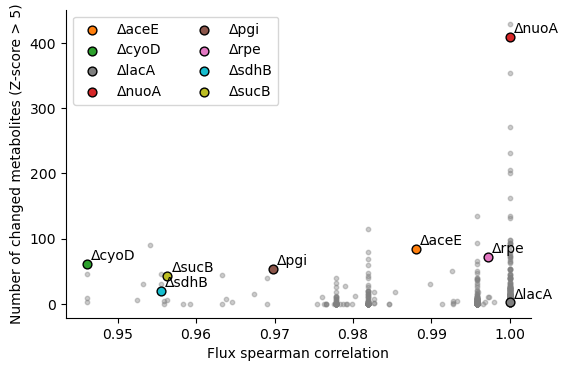

In [27]:
fig, ax = plt.subplots(1, figsize=(6, 4))
corr_kind = 'spearman'
data = 'Flux'

correlation_dict = df.set_index('Gene name')[f'{data} {corr_kind} correlation'].to_dict()


j = 0

for i, row in df.iterrows():
    x = row[f'{data} {corr_kind} correlation']
    try:
        y = n_changes[row["Gene name"]]
    except KeyError:
        # print(i, row["Gene name"])
        continue
    ax.scatter(x,y, c = 'gray', s = 10, alpha = 0.4)
   
    
for i, gene in enumerate(selected_genes):
    y = n_changes[gene]
    if correlation_dict.get(gene):
        x = correlation_dict[gene]
    else:
        x = 1
    ax.scatter(x,y,color = strain_colors[gene], #row['Normalized growth rate'],
           s = 40, label = f'Δ{gene}', edgecolors='k')
    ax.annotate(f'Δ{gene}', (x, y), xytext=(3, 3), textcoords='offset points', fontsize=10)
    # print(row['Gene name'], x, y)
    print(gene, y)
plt.legend(loc='upper left', ncol=2) 
plt.ylabel(f'Number of changed metabolites (Z-score > 5)')
plt.xlabel(f'{data} {corr_kind} correlation')
sns.despine()
# plt.ylim(0, 1200)

plt.savefig(figure_folder / f'strain_selection_correlation_{data}_{corr_kind}_vs_n_changes.png', dpi=300, bbox_inches='tight')
plt.savefig(figure_folder / f'strain_selection_correlation_{data}_{corr_kind}_vs_n_changes.pdf', bbox_inches='tight')